In [93]:
%matplotlib notebook
import matplotlib.pyplot as plt
import random

In [94]:
import random
import time

BOARD_WIDTH = 10
BOARD_HEIGHT = 20
BLANK = 0

TEMPLATE_WIDTH = 5
TEMPLATE_HEIGHT = 5

S_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '..OO.',
                     '.OO..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '...O.',
                     '.....']]

Z_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '.O...',
                     '.....']]

I_SHAPE_TEMPLATE = [['..O..',
                     '..O..',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     'OOOO.',
                     '.....',
                     '.....']]

O_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '.OO..',
                     '.....']]

J_SHAPE_TEMPLATE = [['.....',
                     '.O...',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..OO.',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '...O.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '.OO..',
                     '.....']]

L_SHAPE_TEMPLATE = [['.....',
                     '...O.',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '.O...',
                     '.....'],
                    ['.....',
                     '.OO..',
                     '..O..',
                     '..O..',
                     '.....']]

T_SHAPE_TEMPLATE = [['.....',
                     '..O..',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '..O..',
                     '.....']]

PIECES = {'S': S_SHAPE_TEMPLATE,
          'Z': Z_SHAPE_TEMPLATE,
          'J': J_SHAPE_TEMPLATE,
          'L': L_SHAPE_TEMPLATE,
          'I': I_SHAPE_TEMPLATE,
          'O': O_SHAPE_TEMPLATE,
          'T': T_SHAPE_TEMPLATE}

def initialize_game():
    board = get_blank_board()
    moving_down = False # note: there is no movingUp variable
    moving_left = False
    moving_right = False

    falling_piece = get_new_piece()
    next_piece = get_new_piece()
    state =(board, falling_piece, next_piece)
    return (state, 0, False)

def one_step(state, action):
    board, falling_piece, next_piece = state
    
    if not is_valid_position(board, falling_piece):
        # Game is finished. Return
        return (state, 0, True)

    moving_left = False
    moving_right = False
    moving_down = False

    # moving the piece sideways
    if action == 'L' and is_valid_position(board, falling_piece, adjX=-1):
        falling_piece['x'] -= 1
        moving_left = True

    elif action == 'R' and is_valid_position(board, falling_piece, adjX=1):
        falling_piece['x'] += 1
        moving_right = True

    # rotating the piece (if there is room to rotate)
    elif action == 'W':
        falling_piece['rotation'] = (falling_piece['rotation'] + 1) % len(PIECES[falling_piece['shape']])
        if not is_valid_position(board, falling_piece):
            falling_piece['rotation'] = (falling_piece['rotation'] - 1) % len(PIECES[falling_piece['shape']])
    elif action == 'Q': # rotate the other direction
        falling_piece['rotation'] = (falling_piece['rotation'] - 1) % len(PIECES[falling_piece['shape']])
        if not is_valid_position(board, falling_piece):
            falling_piece['rotation'] = (falling_piece['rotation'] + 1) % len(PIECES[falling_piece['shape']])

    # making the piece fall faster with the down key
    elif action == 'D':
        moving_down = True
        if is_valid_position(board, falling_piece, adjY=1):
            falling_piece['y'] += 1

    # move the current piece all the way down
    elif action == 'S':
        for i in range(1, BOARD_HEIGHT):
            if not is_valid_position(board, falling_piece, adjY=i):
                break
        falling_piece['y'] += i - 1
        
    if not is_valid_position(board, falling_piece, adjY=1):
        # falling piece has landed, set it on the board
        add_to_board(board, falling_piece)
        reward = remove_complete_lines(board)
        falling_piece = next_piece
        next_piece = get_new_piece()
    else:
        # piece did not land, just move the piece down
        falling_piece['y'] += 1
        reward = 0
        
    
    state=(board, falling_piece, next_piece)
    return (state, reward, False)

def get_new_piece():
    # return a random new piece in a random rotation and color
    shape = random.choice(list(PIECES.keys()))
    newPiece = {'shape': shape,
                'rotation': random.randint(0, len(PIECES[shape]) - 1),
                'x': int(BOARD_WIDTH / 2) - int(TEMPLATE_WIDTH / 2),
                'y': -2, # start it above the board (i.e. less than 0)
                'color': random.randint(1, 10)}
    return newPiece

def add_to_board(board, piece):
    # fill in the board based on piece's location, shape, and rotation
    for x in range(TEMPLATE_WIDTH):
        for y in range(TEMPLATE_HEIGHT):
            if PIECES[piece['shape']][piece['rotation']][y][x] != '.':
                board[x + piece['x']][y + piece['y']] = piece['color']

def add_to_board_in_bound(board, piece):
    # fill in the board based on piece's location, shape, and rotation
    for x in range(TEMPLATE_WIDTH):
        for y in range(TEMPLATE_HEIGHT):
            if PIECES[piece['shape']][piece['rotation']][y][x] != '.' and y + piece['y'] >= 0:
                board[x + piece['x']][y + piece['y']] = piece['color']
                
def get_blank_board():
    # create and return a new blank board data structure
    board = []
    for i in range(BOARD_WIDTH):
        board.append([BLANK] * BOARD_HEIGHT)
    return board

def is_on_board(x, y):
    return x >= 0 and x < BOARD_WIDTH and y < BOARD_HEIGHT

def is_valid_position(board, piece, adjX=0, adjY=0):
    # Return True if the piece is within the board and not colliding
    for x in range(TEMPLATE_WIDTH):
        for y in range(TEMPLATE_HEIGHT):
            is_above_board = y + piece['y'] + adjY < 0
            if is_above_board or PIECES[piece['shape']][piece['rotation']][y][x] == '.':
                continue
            if not is_on_board(x + piece['x'] + adjX, y + piece['y'] + adjY):
                return False
            if board[x + piece['x'] + adjX][y + piece['y'] + adjY] != BLANK:
                return False
    return True

def is_complete_line(board, y):
    # Return True if the line filled with boxes with no gaps.
    for x in range(BOARD_WIDTH):
        if board[x][y] == BLANK:
            return False
    return True

def remove_complete_lines(board):
    # Remove any completed lines on the board, move everything above them down, and return the number of complete lines.
    num_lines_removed = 0
    y = BOARD_HEIGHT - 1 # start y at the bottom of the board
    while y >= 0:
        if is_complete_line(board, y):
            # Remove the line and pull boxes down by one line.
            for pull_down_Y in range(y, 0, -1):
                for x in range(BOARD_WIDTH):
                    board[x][pull_down_Y] = board[x][pull_down_Y-1]
            # Set very top line to blank.
            for x in range(BOARD_WIDTH):
                board[x][0] = BLANK
            num_lines_removed += 1
            # Note on the next iteration of the loop, y is the same.
            # This is so that if the line that was pulled down is also
            # complete, it will be removed.
        else:
            y -= 1 # move on to check next row up
    return num_lines_removed
        

TO DO:

    Package everything into a class
    class Tetris(self):
        ....
        ...
        ....
        
    Tetris.onestep(action)=(next state, reward, done)

In [95]:
import numpy as np
import matplotlib.pyplot as plt

In [96]:
def convert_state_to_img(state):
    board = state[0]
    falling_piece = state[1]
    if falling_piece is None:
        return board
    blank = get_blank_board()
    add_to_board_in_bound(blank, falling_piece)
    for i in range(len(board)):
        for j in range(len(board[0])):
            blank[i][j]+=board[i][j]
    return blank

def animate(state, actions):
    %matplotlib
    
    fig = plt.gcf()
    fig.show()
    fig.canvas.draw()
    plt.grid()
    
    for j in range(len(actions)):
        time.sleep(0.2)
        
        state, reward, done = one_step(state, actions[j])
        if done:
            break
        falling_piece_shape = state[1]['shape']
        next_piece_shape = state[2]['shape']
        
        plt.title('Action: ' + actions[j]+', Cur: '+falling_piece_shape+', Next: '+next_piece_shape)
        
        board = convert_state_to_img(state)

        plt.imshow(np.transpose(board), cmap=plt.cm.binary, interpolation='none')
        width = len(board)
        height = len(board[0])
        plt.xlim(-0.5, width-0.5)
        plt.ylim(height-0.5, 0.5)
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, width-0.5, 1))
        ax.set_yticks(np.arange(0.5, height-0.5, 1))
        
        fig.canvas.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


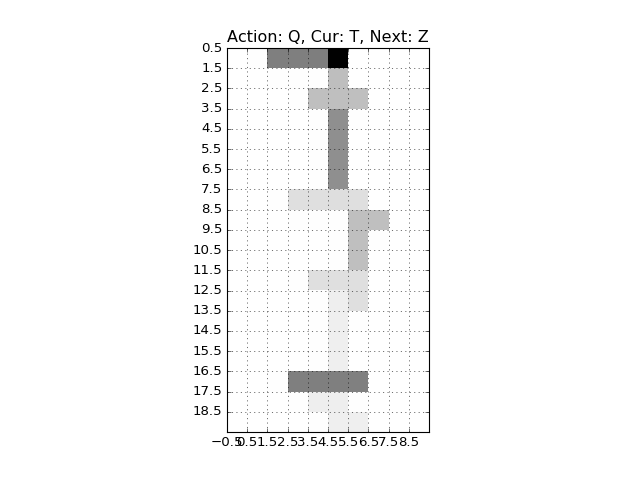

In [97]:
random.seed(2)
state, reward, done = initialize_game()
possible_actions = ['L', 'R', 'D', 'W', 'Q', 'S']
action_length = 100
actions = [possible_actions[random.randint(0, len(possible_actions)-1)] for _ in range(action_length)]

animate(state, actions)

In [92]:
plt.imshow(np.transpose(state[0]), cmap=plt.cm.binary, interpolation='none')
plt.show()